# CH4 Time Series Forecasting
**Objective**: forecast future atmospheric methane concentration

## Input Data
- 'data/processed/ch4_preprocessed.csv'

## Stages
1. load saved model
2. forecast future CH4 concentration

In [1]:
import sys
from pathlib import Path

# print absolute path to forecast_metrics.py
fm_path = Path.cwd().parent / 'src' / 'forecast_metrics.py'
print(f'Expected file path: {fm_path}')
print(f'File exists: {fm_path.exists()}')

Expected file path: C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src\forecast_metrics.py
File exists: True


In [2]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# add both repo root and src/ to path
repo_root = Path.cwd().parent
# sys.path.append(str(repo_root)) 
sys.path.insert(0, str(repo_root)) # insert at start to prioritize
sys.path.insert(0, str(repo_root / 'src')) # add src/ directly

# verify paths
print('\nPython Paths:')
for p in sys.path[:3]:
    print(f'--> {p}')


Python Paths:
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks


# Libraries

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.forecast_metrics import forecast_metrics
print('forecast_metrics imported sucessfully!')

forecast_metrics imported sucessfully!


# Load the Data

In [46]:
# load the preprocessed train and test data (from ../data/processed/), and explicity set the frequency
CH4_train_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

In [20]:
CH4_train_preprocessed.head()

,CH4
date,
1983-05-08,1645.17000
1983-05-15,1650.48025
1983-05-22,1650.48025
1983-05-29,1650.48025
1983-06-05,1638.08600


In [21]:
CH4_test_preprocessed.head()

,CH4
date,
2023-12-31,1948.2575
2024-01-07,1946.6875
2024-01-14,1945.6025
2024-01-21,1946.6875
2024-01-28,1949.8275


In [22]:
CH4_train_logged.head()

,log_ch4_ppb
date,
1983-05-08,7.40560
1983-05-15,7.40882
1983-05-22,7.40882
1983-05-29,7.40882
1983-06-05,7.40128


In [23]:
CH4_test_logged.head()

,log_ch4_ppb
date,
2023-12-31,7.57469
2024-01-07,7.57388
2024-01-14,7.57333
2024-01-21,7.57388
2024-01-28,7.57550


# Load the model

In [24]:
model = SARIMAXResults.load('../results/CH4_best_sarima.pkl')

In [25]:
# verify the model order and seasonal order
print('"CH4_best_sarima": SARIMA(2,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model.model.order)
print('Seasonal order (P, D, Q, s):', model.model.seasonal_order)

"CH4_best_sarima": SARIMA(2,1,0)(1,0,2)[52]
Order (p, d, q): (2, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


# Forecast the CH4 time series data

In [26]:
# forecast the CH4 best SARIMA model results: ARIMA(2,1,0)(1,0,2)[52], trend = 'n', method = 'lbfgs'
# (this is CH4_model_results5 from notebook 4_ch4_modeling)

# create the forecast object  
forecast_object = model.get_forecast(steps=len(CH4_test_preprocessed))

# get mean forecast and confidence intervals
forecast_logged = forecast_object.predicted_mean
forecast_conf_int_logged= forecast_object.conf_int()

# undo log (exponentiate), back-transform the logged values to original scale
forecast = np.exp(forecast_logged)
forecast_conf_int = np.exp(forecast_conf_int_logged)

# set the forecast index to match the test set index
forecast.index = CH4_test_preprocessed.index
forecast_conf_int.index = CH4_test_preprocessed.index

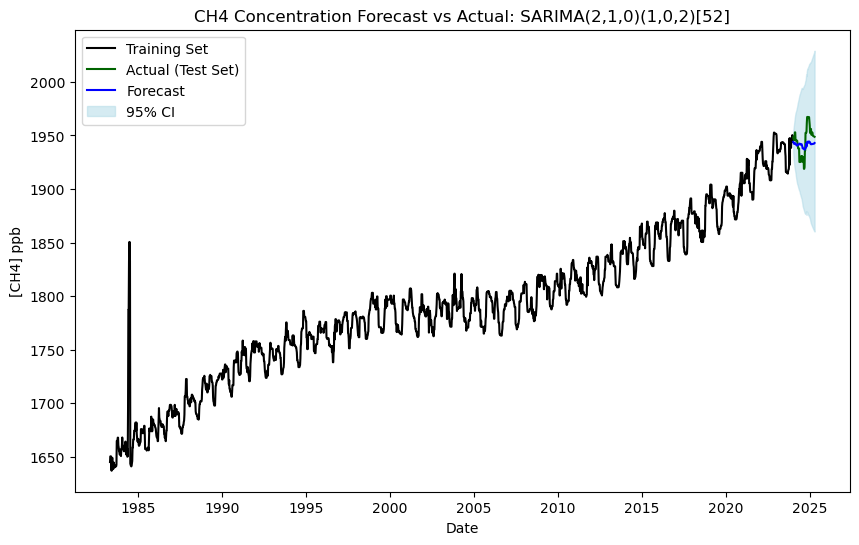

In [27]:
# plot the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_train_preprocessed.index, CH4_train_preprocessed, label='Training Set', color='black')
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(2,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

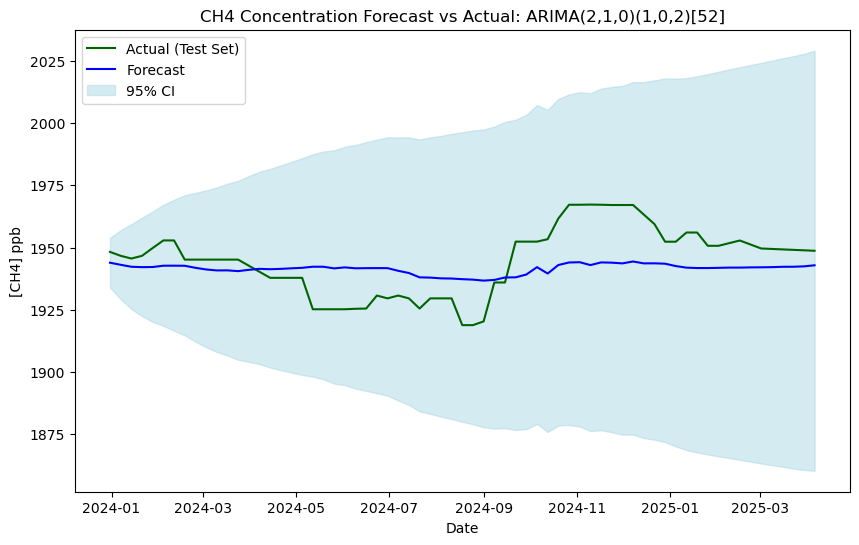

In [28]:
# focus on the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: ARIMA(2,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [29]:
# Forecast metrics

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for SARIMA Predication (2,1,0)(1,0,2,52)')  
forecast_metrics(CH4_test_preprocessed, forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (2,1,0)(1,0,2,52)


{'MAE': 10.819,
 'MSE': 159.493,
 'RMSE': 12.629,
 'MAPE': 0.556,
 'R-squared': 0.109}

## Rolling Forecast

In [30]:
print(CH4_train_logged.index.freq)
print(CH4_test_logged.index.freq)
print(CH4_train_preprocessed.index.freq)
print(CH4_test_preprocessed.index.freq)

<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>


In [43]:
CH4_train_logged.dtypes

log_ch4_ppb    float64
dtype: object

In [49]:
# rolling forecast of model 2: ARIMA(2,1,0)(1,0,2)[52]

# Initialize variables
CH4_train_logged.index.freq = 'W-SUN'
CH4_test_logged.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_logged['log_ch4_ppb'].copy()  # Your initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

# Rolling forecast loop
for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(2,1,0), seasonal_order=(1,0,2,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_logged['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

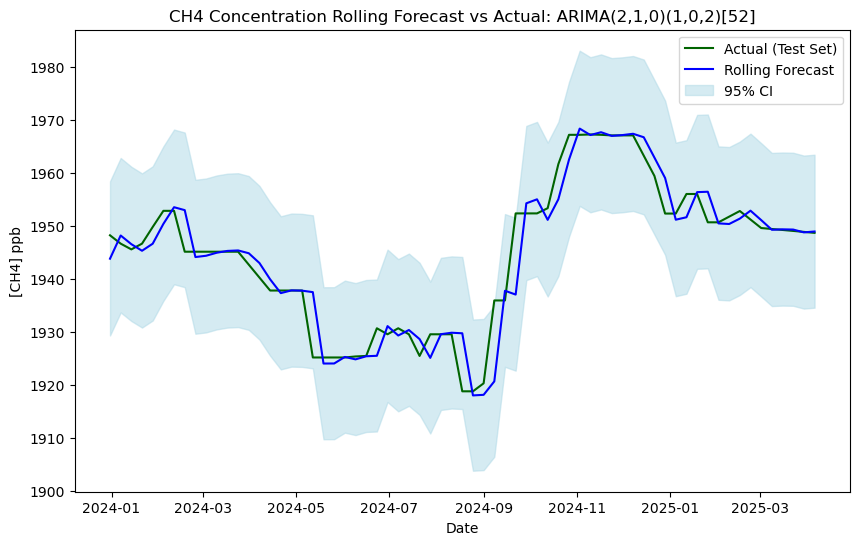

In [51]:
# plot the rolling forecast results 

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(2,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [52]:
# Forecast results for rolling forecast of model 2: ARIMA(2,1,0)(1,0,2)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(2,1,0)(1,0,2,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(2,1,0)(1,0,2,52)


{'MAE': 2.438, 'MSE': 17.13, 'RMSE': 4.139, 'MAPE': 0.125, 'R-squared': 0.904}

### Autocorrelation analysis of rolling forecast model residuals

In [54]:
# Calculate the residuals from the rolling forecast models 

# ARIMA(2,1,0)(1,0,2)[52]
CH4_rolling_forecast_residuals = (np.exp(CH4_test_logged['log_ch4_ppb']) - CH4_rolling_forecast)
CH4_rolling_forecast_residuals = pd.Series(
    CH4_rolling_forecast_residuals, 
    index=CH4_test_preprocessed.index
)

PACF function uses the Yule-Walker method to calculate the partial autocorrelation function (OLS method).  To avoid overfitting and ensure numerical stability, statsmodels enforces that # lags < 50% of the # observations. Since my test set is 67 data points in length, I am limited to 32 lags.  Two possible ways forward with the residuals test for autocorrelation:

1. move forward as is and interpret ACF based on 52 lags and PACF based on 32 lags.  
2. Go back and change the test set to include 106 data points (nlags < len(residuals) // 2).  

I will choose option 1 and determine if I need to change the data split ratio after I see the results.

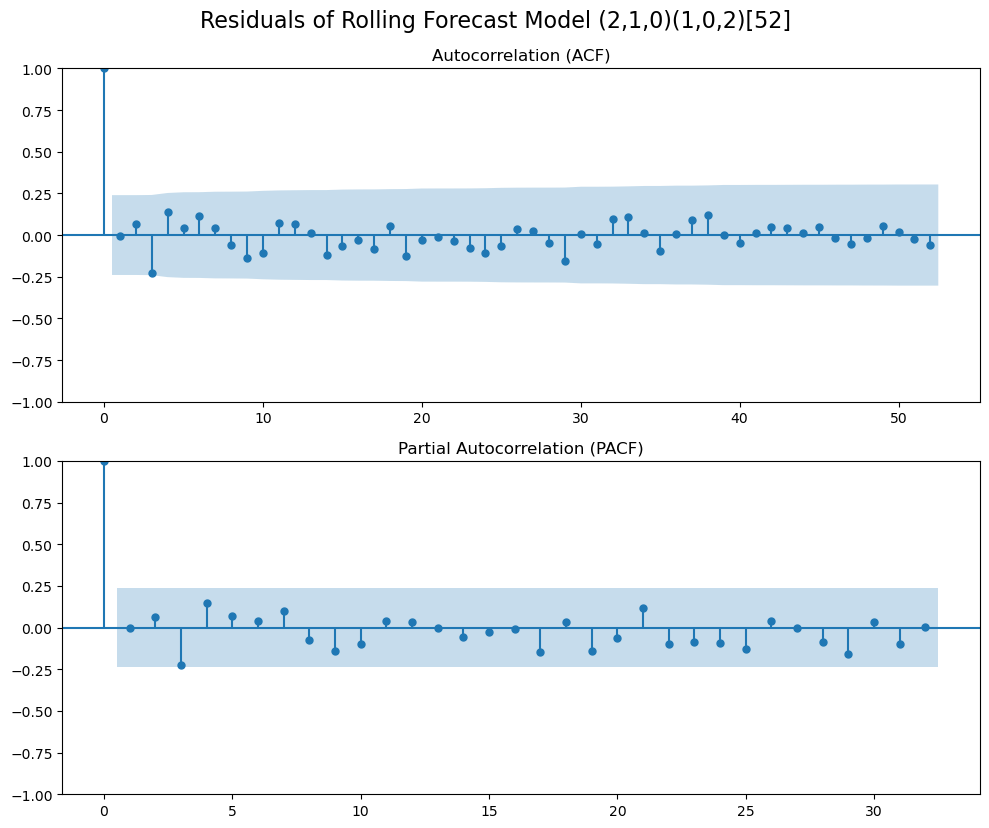

In [66]:
fig, axs = plt.subplots(2,1, figsize=(10,8))

plot_acf(
    CH4_rolling_forecast_residuals, 
    lags=52, 
    ax=axs[0],
    title='Autocorrelation (ACF)'
)

plot_pacf(
    CH4_rolling_forecast_residuals, 
    lags=32, 
    ax=axs[1],
    title='Partial Autocorrelation (PACF)'
)

plt.tight_layout()
plt.suptitle('Residuals of Rolling Forecast Model (2,1,0)(1,0,2)[52]', fontsize=16, y=1.03)
plt.show()

All lags are within the CI (95%) so aren't significant, but the pattern suggests that there is possible room to improve the model tune.  

In [70]:
# Ljung-Box test

lb_test = acorr_ljungbox(CH4_rolling_forecast_residuals, lags=[7,15,26,52], return_df=True)
    
print('Ljung-Box Test Results for SARIMA((2,1,0)(1,0,2)[52]) Rolling Forecast Model\n')
print(lb_test)

Ljung-Box Test Results for SARIMA((2,1,0)(1,0,2)[52]) Rolling Forecast Model

      lb_stat  lb_pvalue
7    6.635253   0.467818
15  11.796732   0.694345
26  17.069005   0.906983
52  32.700396   0.983329


There are no significant lags and the Ljung-Box test p-values are > 0.05 at all specified lags. Therefore, there is no autocorrelation remaining in the residuals and the models have captured the non-seasonal and seasonal structure in the data.  

# CH4 future forecasting

## Load the full, preprocessed dataset

In [74]:
CH4_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

## Re-train the model on the full dataset

In [75]:
print(CH4_preprocessed.index.freq)
print(CH4_preprocessed.index.min())
print(CH4_preprocessed.index.max())

<Week: weekday=6>
1983-05-08 00:00:00
2025-04-06 00:00:00


In [76]:
# log transform the entire dataset
CH4_preprocessed_logged = np.log(CH4_preprocessed) 

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9362.643
Date:                                 Mon, 09 Jun 2025   AIC                         -18713.286
Time:                                         14:42:59   BIC                         -18679.439
Sample:                                     05-08-1983   HQIC                        -18700.883
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0701      0.016      4.316      0.000       0.038       0

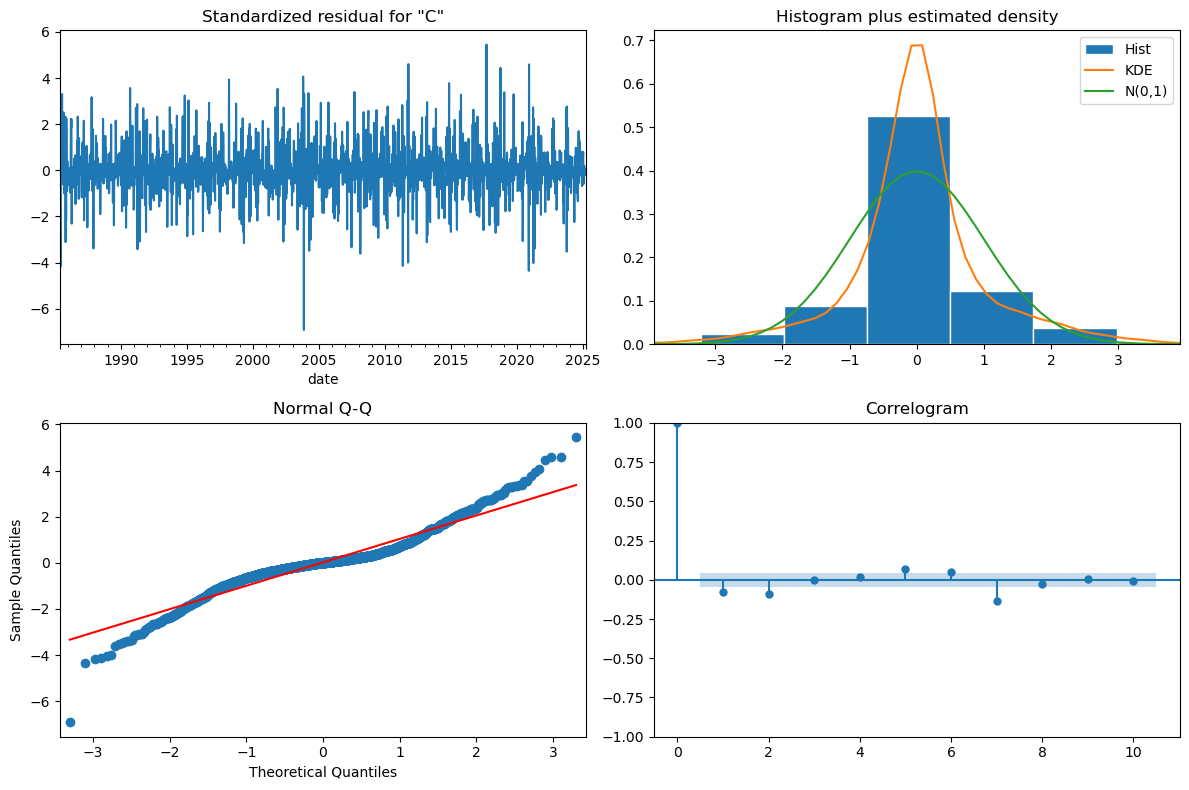

In [93]:
# I will re-train the SARIMA(2,1,0)(1,0,2)[52] model with the entire dataset 

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- AIC = -18713, BIC = -18679, which are good, low values
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- all coefficients are statistically significant
- Standardized residuals: random, no clear patterns

negatives:
- The Jarque-Bera test and QQ plot shows non-normal distribution with heavy tails
- Ljung-Box test shows that some autocorrelation remains, and can be seen at lag 1, mayb lag 2 of the correlogram



                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood                9383.164
Date:                                 Mon, 09 Jun 2025   AIC                         -18752.329
Time:                                         14:56:34   BIC                         -18712.844
Sample:                                     05-08-1983   HQIC                        -18737.860
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0258      0.164      0.157      0.875      -0.296       0

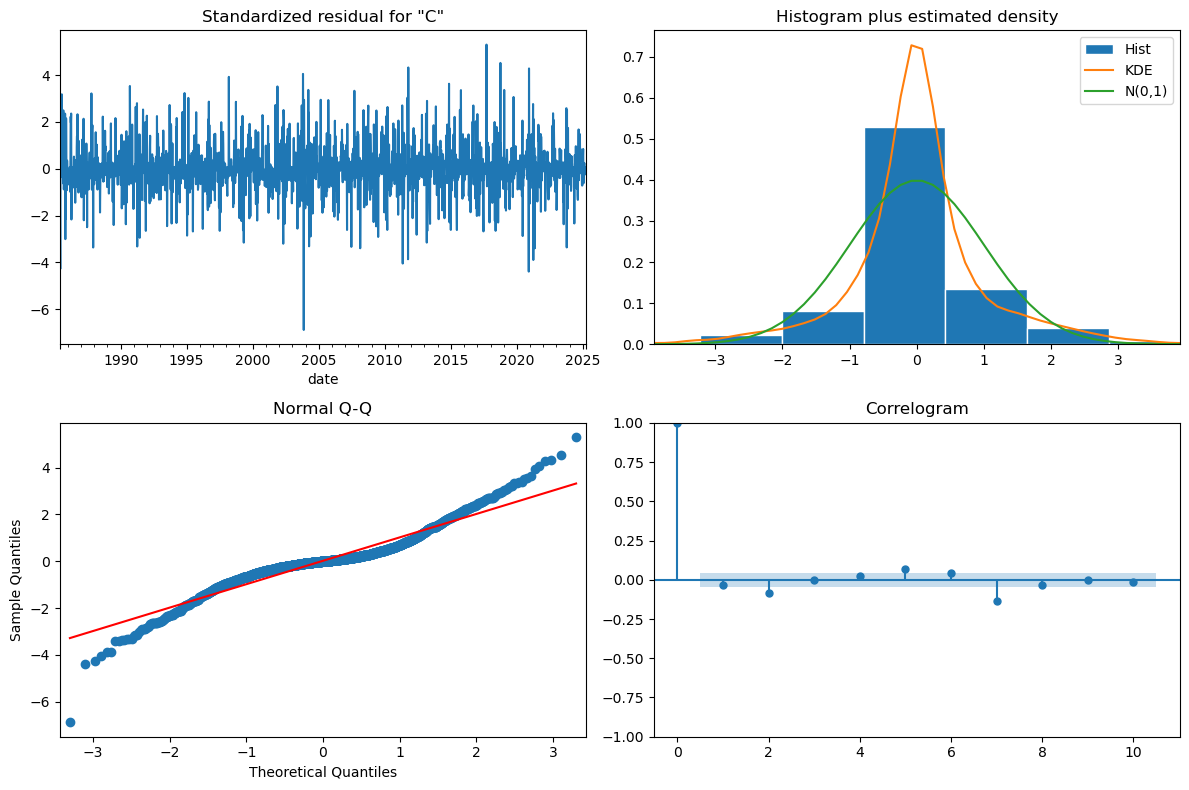

In [94]:
# I will try adding a non-seasonal MA term to address the autocorrelation observed at lag 1
# SARIMA(2,1,1)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,1),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9445.101
Date:                                 Mon, 09 Jun 2025   AIC                         -18880.202
Time:                                         14:18:14   BIC                         -18851.997
Sample:                                     05-08-1983   HQIC                        -18869.867
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0490      0.016     -2.999      0.003      -0.081      -0

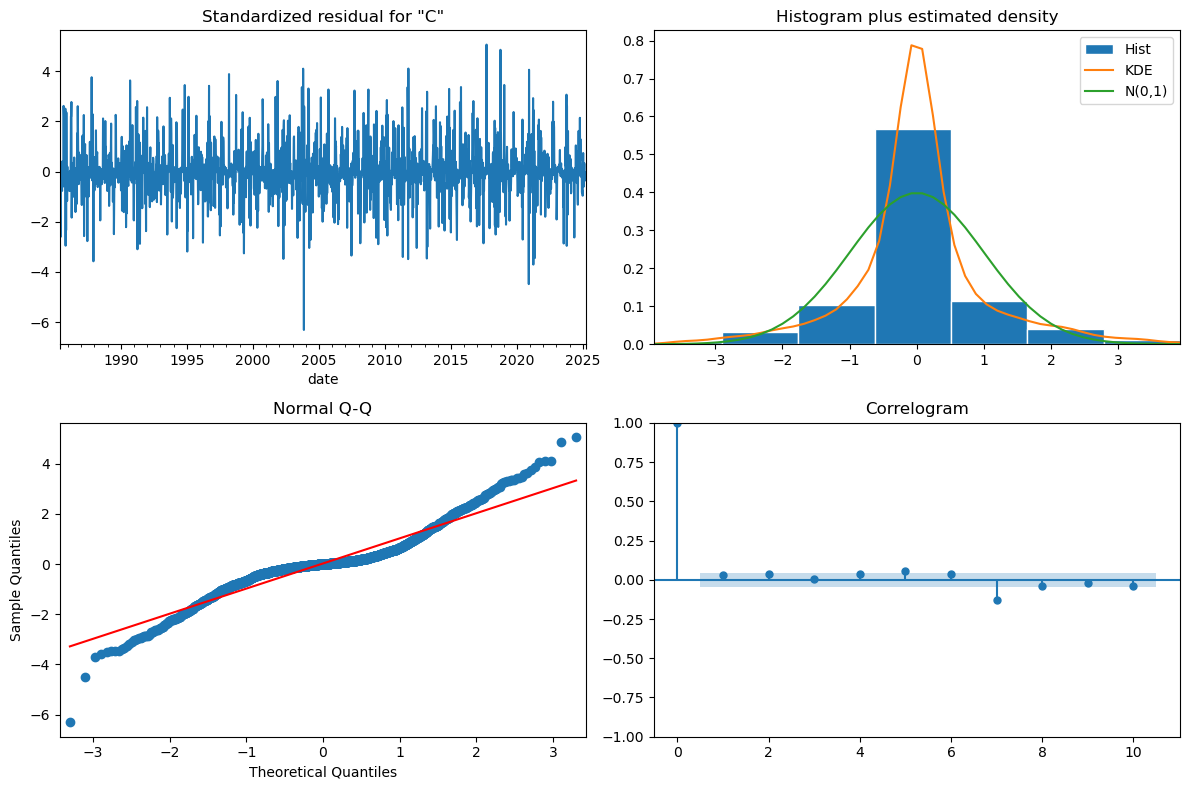

In [92]:
# adding the non-seasonal MA(1) term improved the model by eliminating the autocorrelation and lag 1, 
# increasing the log likelihood, and decreasing both AIC and BIC values.  However, now, non-seasonal terms 
# ar(L1) and ma(l1) became statistically insignificant.  
# SARIMA(1,1,0)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(1,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- log-likelihood increased from 9362 to 9445
- AIC decreased from -18713 to -18880
- BIC decreased from -18679 to -18852
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- Standardized residuals: random, no clear patterns
- Ljung-Box test and correlogram present homoscedastic behavior

negatives:
- the seasonal AR term (AR.S.L52) is not statistically significant.  However, removing this term (i.e. (1,1,0)(0,0,[1,2])[52]) produced substantially worse metrics, data histogram, QQ plot and correlogram.  
- The Jarque-Bera test and QQ plot still shows non-normal distribution with heavy tails

The SARIMA(1,1,0)(1,0,2)[52] is a better and more simple model compared to SARIMA(2,1,0)(1,0,2)[52] on the full dataset.  

## Test New Parameters on Train & Test Sets

In [97]:
# Rolling forecast loop for SARIMA(1,1,0)(1,0,2)[52]

# Initialize variables
CH4_train_logged.index.freq = 'W-SUN'
CH4_test_logged.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_logged['log_ch4_ppb'].copy()  # Your initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,2,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_logged['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

In [102]:
# verify the order and seasonal order
print('"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model_fit.model.order)
print('Seasonal order (P, D, Q, s):', model_fit.model.seasonal_order)

"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


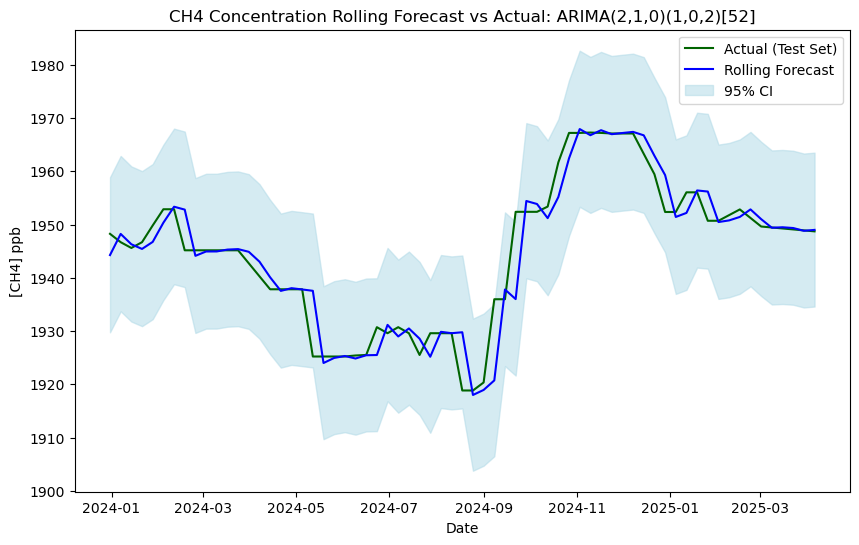

In [98]:
# plot the rolling forecast results for SARIMA(1,1,0)(1,0,2)[52]

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(1,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [99]:
# Evaluation metrics for rolling forecast of SARIMA(1,1,0)(1,0,2)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)


{'MAE': 2.378, 'MSE': 17.302, 'RMSE': 4.16, 'MAPE': 0.122, 'R-squared': 0.903}

Compare SARIMA(1,1,0)(1,0,2,52) vs SARIMA(2,1,0)(1,0,2,52)

Evaluation Metrics for Rolling Forecast, SARIMA(2,1,0)(1,0,2,52)
{'MAE': 2.438, 'MSE': 17.13, 'RMSE': 4.139, 'MAPE': 0.125, 'R-squared': 0.904}

The differences in evaluation metrics are minimal.  Considering that the simpler model has better log likelihood, AIC, and BIC scores and results in residuals that are homescedastic and no autocorrelation, SARIMA(1,1,0)(1,0,2,52) is the better model.    

# Save the Final Model

In [100]:
import joblib 
from datetime import datetime

CH4_best_model = SARIMAX(
    CH4_preprocessed_logged, 
    order=(1,1,0), 
    seasonal_order=(1,0,2,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results = CH4_best_model.fit(method='lbfgs')

# save with metadata
CH4_model_artifacts = {
    'results': CH4_model_results,
    'config': {
        'order': (1,1,0),
        'seasonal_order': (1,0,2,52),
        'last_training_date': CH4_preprocessed_logged.index[-1].strftime('%Y-%m-%d'),
        'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

# save for production
joblib.dump(CH4_model_artifacts, '../results/CH4_full_dataset_best_sarima.pkl')
print(f'Model saved at {datetime.now()} for production use')

Model saved at 2025-06-10 12:10:05.789361 for production use


## Forecast CH4 concentration for future periods

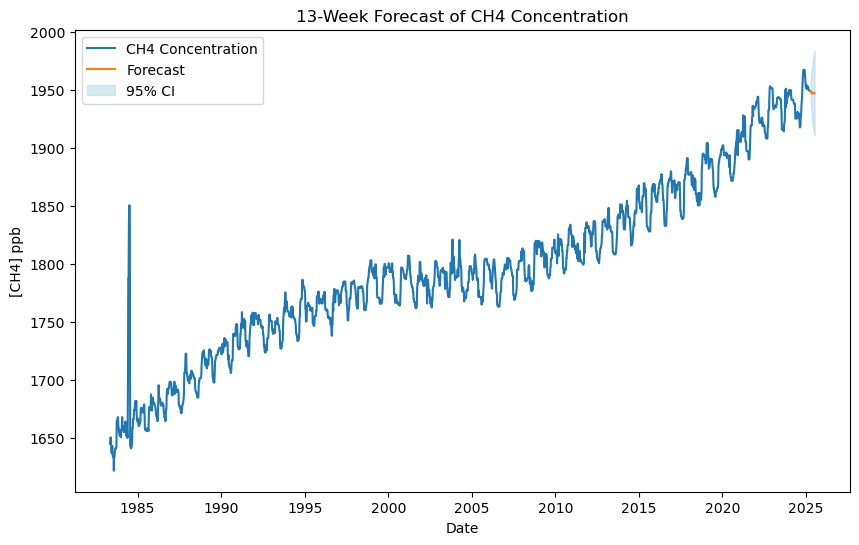

In [ ]:
forecast_steps = 13
CH4_forecast = CH4_final_model_fit.get_forecast(steps=forecast_steps)
CH4_forecast_mean = np.exp(CH4_forecast.predicted_mean)
CH4_forecast_conf_int = np.exp(CH4_forecast.conf_int())

CH4_forecast_index = pd.date_range(
    CH4_preprocessed.index[-1],
    periods=forecast_steps + 1,
    freq='W-SUN')[1:]  # Exclude the first date (last date of training set)
    
# plot the forecast results for model 5: ARIMA(2,1,0)(1,0,2)[52]
plt.figure(figsize=(10,6))
plt.plot(CH4_preprocessed.index, CH4_preprocessed, label='CH4 Concentration')
plt.plot(CH4_forecast_index, CH4_forecast_mean, label='Forecast')
plt.fill_between(
    CH4_forecast_index, 
    CH4_forecast_conf_int.iloc[:, 0], 
    CH4_forecast_conf_int.iloc[:, 1], 
    color='lightblue', 
    alpha=0.5, 
    label='95% CI'
)
plt.title('13-Week Forecast of CH4 Concentration')
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.legend()
plt.show()

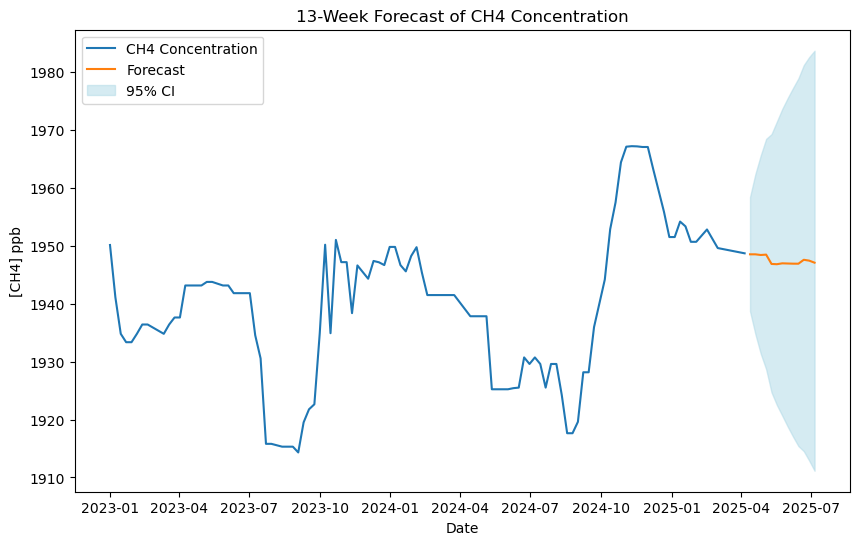

In [119]:
# focus more on the forecast results for model 5: ARIMA(2,1,0)(1,0,2)[52]

cutoff_date = pd.Timestamp('2023-01-01')
CH4_preprocessed_2023 = CH4_preprocessed[CH4_preprocessed.index >= cutoff_date]

plt.figure(figsize=(10,6))
plt.plot(CH4_preprocessed_2023.index, CH4_preprocessed_2023, label='CH4 Concentration')
plt.plot(CH4_forecast_index, CH4_forecast_mean, label='Forecast')
plt.fill_between(
    CH4_forecast_index, 
    CH4_forecast_conf_int.iloc[:, 0], 
    CH4_forecast_conf_int.iloc[:, 1], 
    color='lightblue', 
    alpha=0.5, 
    label='95% CI'
)
plt.title('13-Week Forecast of CH4 Concentration')
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.legend()
plt.show()

In [120]:
print(CH4_forecast_mean)
print(CH4_forecast_conf_int)
print(CH4_forecast_index)

2025-04-13    1948.547766
2025-04-20    1948.545677
2025-04-27    1948.431524
2025-05-04    1948.495536
2025-05-11    1946.882445
2025-05-18    1946.838411
2025-05-25    1946.990465
2025-06-01    1946.960689
2025-06-08    1946.931340
2025-06-15    1946.924956
2025-06-22    1947.603267
2025-06-29    1947.455300
2025-07-06    1947.102953
Freq: W-SUN, Name: predicted_mean, dtype: float64
              lower CH4    upper CH4
2025-04-13  1938.713286  1958.432132
2025-04-20  1934.760525  1962.429048
2025-04-27  1931.367118  1965.646701
2025-05-04  1928.698770  1968.495503
2025-05-11  1924.702584  1969.317901
2025-05-18  1922.498981  1971.485986
2025-05-25  1920.668363  1973.673303
2025-06-01  1918.799877  1975.534796
2025-06-08  1917.047142  1977.281392
2025-06-15  1915.413280  1978.955050
2025-06-22  1914.534404  1981.243313
2025-06-29  1912.913696  1982.620624
2025-07-06  1911.154646  1983.727438
DatetimeIndex(['2025-04-13', '2025-04-20', '2025-04-27', '2025-05-04',
               '2025-05

# Save the model for future use

In [121]:
import joblib

joblib.dump(CH4_final_model_fit, 'CH4_forecast_model.pkl')

['CH4_forecast_model.pkl']

In [ ]:
# End